## Imports

In [1]:
import sys
sys.path.insert(0, '/root/')

In [2]:
from tpqoa import tpqoa
import numpy as np
import pandas as pd
import tables as tb
import tstables as tstb
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')

## Connecting to the Oanda API

In [3]:
oanda = tpqoa('/root/pyalgo.cfg')

In [4]:
instrument_1 = 'AUD_USD'

In [5]:
month1 = oanda.get_history(instrument_1,
                          start = '2017-12-31',
                          end = '2018-2-1',
                          granularity = 'M10',
                          price = 'A')

In [6]:
month2 = oanda.get_history(instrument_1,
                          start = '2018-2-1',
                          end = '2018-3-1',
                          granularity ='M10',
                          price = 'A')

In [7]:
month3 = oanda.get_history(instrument_1,
                        start = '2018-3-1',
                        end = '2018-3-31',
                        granularity = 'M10',
                        price = 'A')

In [8]:
month4 = oanda.get_history(instrument_1,
                        start = '2018-3-31',
                        end = '2018-4-30',
                        granularity = 'M10',
                        price = 'A')

In [9]:
month1cls = month1['c']
month2cls = month2['c']
month3cls = month3['c']
month4cls = month4['c']

In [10]:
seg_data = [month1cls, month2cls, month3cls, month4cls]

In [11]:
fulldata = pd.concat(seg_data)

# storage with HDF5

In [12]:
h5 = pd.HDFStore('/root/pyalgocourse/test_project/data.h5','w')

In [13]:
h5['data'] = fulldata

In [14]:
h5

<class 'pandas.io.pytables.HDFStore'>
File path: /root/pyalgocourse/test_project/data.h5
/data            series       (shape->[12108])

In [15]:
ls -n data.*

-rw-r--r-- 1 0 0 198816 May 22 06:31 data.h5


In [16]:
h5.close()

## Start with data saved from HDF5 file

In [17]:
h5 = pd.HDFStore('/root/pyalgocourse/test_project/data.h5','r')

In [18]:
fulldata_copy = h5['data']

In [19]:
h5.close()

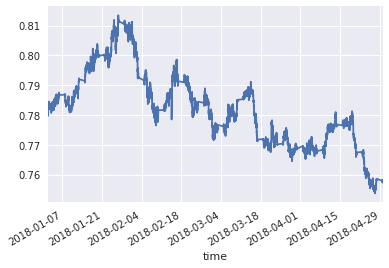

In [20]:
fulldata_copy.plot();

## Calculate parameters for data

In [21]:
# https://github.com/mtamer/python-rsi/blob/master/Stock%20Screener/rsi.py

In [22]:
def relative_strength(data, n = 21):
     
    abchange = (data - data.shift(1))
    rsperiod = abchange[:n + 1]
    upday = rsperiod[rsperiod >= 0].sum() / n
    dnday = -rsperiod[rsperiod < 0].sum() / n
    rs = upday / dnday
    rsi = np.zeros_like(data)
    rsi[:n] = 100. - (100. / ( 1. + rs))
    
    for i in range(n, len(data)):
        abchg = abchange[i - 1]
        if abchg > 0:
            upval = abchg
            dnval = 0
        else:
            upval = 0
            dnval = abs(abchg)
            
        upday = (upday * (n - 1) + upval) / n
        dnday = (dnday * (n - 1) + dnval) / n
        
        rs = upday / dnday
        rsi[i] = 100. - (100. / ( 1. + rs))
        
    
    rsi = pd.DataFrame(rsi)
    rsi.index = fulldata_copy.index
    rsi.columns = ['RSI']
    return rsi
    

In [23]:
rsi = relative_strength(fulldata_copy)

In [24]:
fulldata_copy = pd.DataFrame(fulldata_copy)

In [25]:
fulldata_copy.head()

,c
time,
2018-01-01 22:00:00,0.78072
2018-01-01 22:10:00,0.78067
2018-01-01 22:20:00,0.78069
2018-01-01 22:30:00,0.78054
2018-01-01 22:40:00,0.78083


In [26]:
fulldata_copy['RSI'] = rsi['RSI']

In [27]:
fulldata_copy.head()

,c,RSI
time,,
2018-01-01 22:00:00,0.78072,63.131313
2018-01-01 22:10:00,0.78067,63.131313
2018-01-01 22:20:00,0.78069,63.131313
2018-01-01 22:30:00,0.78054,63.131313
2018-01-01 22:40:00,0.78083,63.131313


In [28]:
fulldata_copy.columns = ['AUDUSD','RSI']

In [29]:
fulldata_copy['MACD'] = fulldata_copy['AUDUSD'].ewm(span = 26).mean() - fulldata_copy['AUDUSD'].ewm(span = 12).mean()

In [30]:
fulldata_copy['Returns'] = np.log(fulldata_copy['AUDUSD'] / fulldata_copy['AUDUSD'].shift(1))

In [31]:
fulldata_copy.head()

,AUDUSD,RSI,MACD,Returns
time,,,,
2018-01-01 22:00:00,0.78072,63.131313,0.000000e+00,NaN
2018-01-01 22:10:00,0.78067,63.131313,1.121795e-06,-0.000064
2018-01-01 22:20:00,0.78069,63.131313,8.091905e-07,0.000026
2018-01-01 22:30:00,0.78054,63.131313,6.062874e-06,-0.000192
2018-01-01 22:40:00,0.78083,63.131313,-2.749760e-06,0.000371


In [32]:
fulldata_copy.tail()

,AUDUSD,RSI,MACD,Returns
time,,,,
2018-04-29 23:10:00,0.75740,49.180254,-0.000010,-0.000172
2018-04-29 23:20:00,0.75728,47.251147,0.000030,-0.000158
2018-04-29 23:30:00,0.75745,45.520534,0.000048,0.000224
2018-04-29 23:40:00,0.75760,48.335277,0.000049,0.000198
2018-04-29 23:50:00,0.75740,50.695350,0.000066,-0.000264


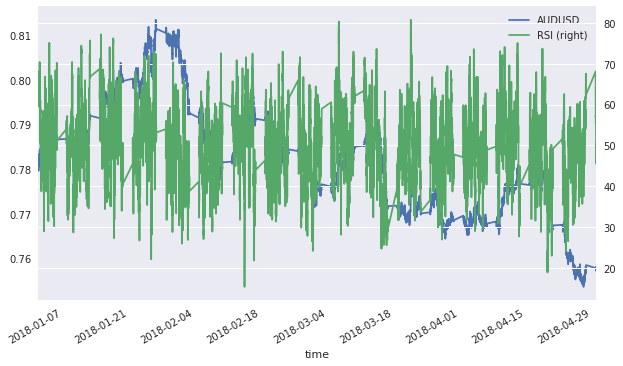

In [33]:
fulldata_copy[['AUDUSD','RSI']].plot(figsize=(10,6),secondary_y = 'RSI');

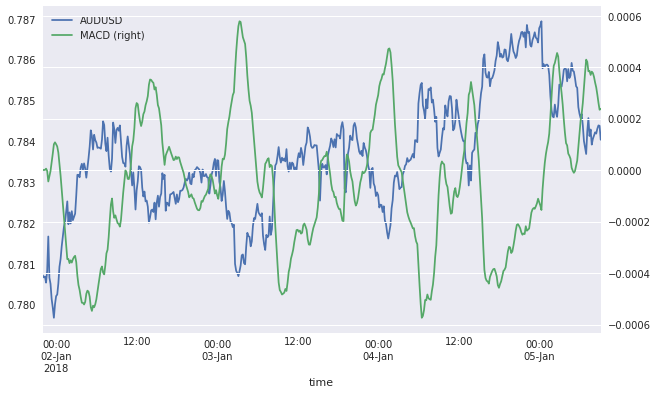

In [34]:
fulldata_copy[['AUDUSD','MACD']][:500].plot(figsize=(10,6),secondary_y = 'MACD');

In [35]:
lags = 30
cols = []
for lags in range(1, lags + 1):
    col = 'lag_%d' % lags
    fulldata_copy[col] = fulldata_copy['Returns'].shift(lags)
    cols.append(col)

In [36]:
fulldata_copy.tail()

,AUDUSD,RSI,MACD,Returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30
time,,,,,,,,,,,,,,,,,,,,,
2018-04-29 23:10:00,0.75740,49.180254,-0.000010,-0.000172,-0.000119,-0.000106,-0.000330,-0.000185,0.000106,0.000040,...,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.000449,0.000594,0.000079,0.000172
2018-04-29 23:20:00,0.75728,47.251147,0.000030,-0.000158,-0.000172,-0.000119,-0.000106,-0.000330,-0.000185,0.000106,...,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.000449,0.000594,0.000079
2018-04-29 23:30:00,0.75745,45.520534,0.000048,0.000224,-0.000158,-0.000172,-0.000119,-0.000106,-0.000330,-0.000185,...,-0.000132,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.000449,0.000594
2018-04-29 23:40:00,0.75760,48.335277,0.000049,0.000198,0.000224,-0.000158,-0.000172,-0.000119,-0.000106,-0.000330,...,-0.000040,-0.000132,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.000449
2018-04-29 23:50:00,0.75740,50.695350,0.000066,-0.000264,0.000198,0.000224,-0.000158,-0.000172,-0.000119,-0.000106,...,0.000106,-0.000040,-0.000132,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198


In [37]:
fulldata_copy['MOM1'] = np.where(fulldata_copy['Returns'].rolling(10).mean() > 0, 1, 0)
fulldata_copy['MOM1'] = fulldata_copy['MOM1'].shift(1)
cols.append('MOM1')
fulldata_copy['MOM2'] = np.where(fulldata_copy['Returns'].rolling(50).mean() > 0, 1, 0)
fulldata_copy['MOM2'] = fulldata_copy['MOM2'].shift(1)
cols.append('MOM2')
cols.append('RSI')
cols.append('MACD')

In [38]:
cols

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12',
 'lag_13',
 'lag_14',
 'lag_15',
 'lag_16',
 'lag_17',
 'lag_18',
 'lag_19',
 'lag_20',
 'lag_21',
 'lag_22',
 'lag_23',
 'lag_24',
 'lag_25',
 'lag_26',
 'lag_27',
 'lag_28',
 'lag_29',
 'lag_30',
 'MOM1',
 'MOM2',
 'RSI',
 'MACD']

In [39]:
fulldata_copy.tail()

,AUDUSD,RSI,MACD,Returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,MOM1,MOM2
time,,,,,,,,,,,,,,,,,,,,,
2018-04-29 23:10:00,0.75740,49.180254,-0.000010,-0.000172,-0.000119,-0.000106,-0.000330,-0.000185,0.000106,0.000040,...,-0.000026,0.000026,0.000119,0.000198,0.000449,0.000594,0.000079,0.000172,0.0,1.0
2018-04-29 23:20:00,0.75728,47.251147,0.000030,-0.000158,-0.000172,-0.000119,-0.000106,-0.000330,-0.000185,0.000106,...,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.000449,0.000594,0.000079,0.0,1.0
2018-04-29 23:30:00,0.75745,45.520534,0.000048,0.000224,-0.000158,-0.000172,-0.000119,-0.000106,-0.000330,-0.000185,...,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.000449,0.000594,0.0,1.0
2018-04-29 23:40:00,0.75760,48.335277,0.000049,0.000198,0.000224,-0.000158,-0.000172,-0.000119,-0.000106,-0.000330,...,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.000449,0.0,1.0
2018-04-29 23:50:00,0.75740,50.695350,0.000066,-0.000264,0.000198,0.000224,-0.000158,-0.000172,-0.000119,-0.000106,...,-0.000132,-0.000185,-0.000026,-0.000066,-0.000026,0.000026,0.000119,0.000198,0.0,1.0


In [40]:
fulldata_copy.dropna(inplace = True)

In [41]:
fulldata_copy.head()

,AUDUSD,RSI,MACD,Returns,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,MOM1,MOM2
time,,,,,,,,,,,,,,,,,,,,,
2018-01-02 03:10:00,0.78318,63.690322,-0.000410,0.000651,0.000562,0.000102,0.000102,-0.000281,0.000384,-0.000345,...,-0.000474,-0.000192,-0.001293,0.001075,0.000371,-0.000192,0.000026,-0.000064,1.0,0.0
2018-01-02 03:20:00,0.78318,66.794347,-0.000446,0.000000,0.000651,0.000562,0.000102,0.000102,-0.000281,0.000384,...,-0.000269,-0.000474,-0.000192,-0.001293,0.001075,0.000371,-0.000192,0.000026,1.0,0.0
2018-01-02 03:30:00,0.78312,66.794347,-0.000465,-0.000077,0.000000,0.000651,0.000562,0.000102,0.000102,-0.000281,...,-0.000321,-0.000269,-0.000474,-0.000192,-0.001293,0.001075,0.000371,-0.000192,1.0,0.0
2018-01-02 03:40:00,0.78336,66.061838,-0.000493,0.000306,-0.000077,0.000000,0.000651,0.000562,0.000102,0.000102,...,0.000423,-0.000321,-0.000269,-0.000474,-0.000192,-0.001293,0.001075,0.000371,1.0,0.0
2018-01-02 03:50:00,0.78345,67.556195,-0.000515,0.000115,0.000306,-0.000077,0.000000,0.000651,0.000562,0.000102,...,0.000256,0.000423,-0.000321,-0.000269,-0.000474,-0.000192,-0.001293,0.001075,1.0,0.0


# storage with HDF5

In [42]:
h6 = pd.HDFStore('/root/pyalgocourse/test_project/data_features.h5','w')

In [43]:
h6['data'] = fulldata_copy

In [44]:
h6

<class 'pandas.io.pytables.HDFStore'>
File path: /root/pyalgocourse/test_project/data_features.h5
/data            frame        (shape->[12077,36])

In [45]:
ls -n data.*

-rw-r--r-- 1 0 0 198816 May 22 06:31 data.h5


In [46]:
h6.close()